Purpose of this notebook is to investigate the data to understand it before it can be fed to our ambient occlusion neural net.

We will be generally following the instructions laid out in the paper:

http://theorangeduck.com/media/uploads/other_stuff/nnao.pdf 

and in the code sample:

http://theorangeduck.com/media/uploads/other_stuff/nnao_demo.zip

in `process.py`

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '/home/yvan/Downloads/nnao_demo/data/raw'

In [3]:
dirs = os.listdir(DATA_DIR)

In [4]:
for d in dirs:
    print(d)
    ds = os.listdir(os.path.join(DATA_DIR, d))
    print(f'     {ds[:5]}')
    for d2 in ds:
        print(f'     {d2}')
        ds2 = os.listdir(os.path.join(DATA_DIR, d, d2))
        print(f'          {ds2[:5]}')
        print(len(ds2))
    

mesa1
     ['normalCam', 'AO']
     normalCam
          ['mesa1.141.bin', 'mesa1.90.bin', 'mesa1.85.bin', 'mesa1.110.bin', 'mesa1.150.bin']
150
     AO
          ['mesa1.141.bin', 'mesa1.90.bin', 'mesa1.85.bin', 'mesa1.110.bin', 'mesa1.150.bin']
150
mesa4
     ['normalCam', 'AO']
     normalCam
          ['mesa4.66.bin', 'mesa4.36.bin', 'mesa4.45.bin', 'mesa4.27.bin', 'mesa4.70.bin']
100
     AO
          ['mesa4.66.bin', 'mesa4.36.bin', 'mesa4.45.bin', 'mesa4.27.bin', 'mesa4.70.bin']
100
mesa3
     ['normalCam', 'AO']
     normalCam
          ['mesa3.131.bin', 'mesa3.89.bin', 'mesa3.15.bin', 'mesa3.63.bin', 'mesa3.4.bin']
150
     AO
          ['mesa3.131.bin', 'mesa3.89.bin', 'mesa3.15.bin', 'mesa3.63.bin', 'mesa3.4.bin']
150
mesa2
     ['normalCam', 'AO']
     normalCam
          ['mesa2.128.bin', 'mesa2.20.bin', 'mesa2.80.bin', 'mesa2.99.bin', 'mesa2.115.bin']
150
     AO
          ['mesa2.128.bin', 'mesa2.20.bin', 'mesa2.80.bin', 'mesa2.99.bin', 'mesa2.115.bin']
150
mesa_props
   

So it looks like What we have is a bunch of `mesa_` folders which each contain a folder called `AO` and `normalCam` and each of these contains .bin files. Each .bin file is some kind of  art asset. In `process.py` the authors use numpy to read the files. So that is what we will do.

normalCam should have 4 dimensions. I think 3 of the dims are RGB and 4th dimension is marked 'D' in the original process.py file. Not sure what that is. 

AO is the ambient occlusion label (just guessing here, didn't acutally read that anywhere).

In [5]:
# get each folder and how many images are in it.
databases = [
    ('mesa1',      150),
    ('mesa2',      150),
    ('mesa3',      150),
    ('mesa4',      100),
    ('mesa_props', 100),
]
sample1 = os.path.join(DATA_DIR, 'mesa1', 'AO', 'mesa1.1.bin')
sample2 = os.path.join(DATA_DIR, 'mesa1', 'normalCam', 'mesa1.1.bin')
sample_array1 = np.fromfile(sample1, dtype=np.float32).reshape(720,1280,1)
sample_array2 = np.fromfile(sample2, dtype=np.float32).reshape(720,1280,4)

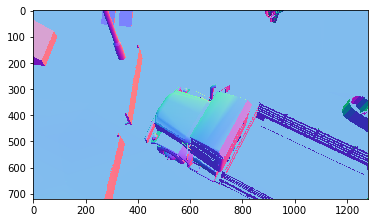

In [6]:
_ = plt.imshow(sample_array2)

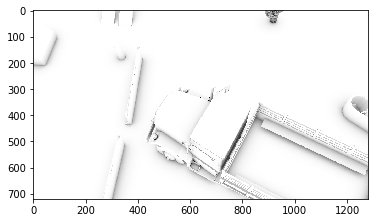

In [7]:
_ = plt.imshow(sample_array1.squeeze(),cmap='Greys')

In [8]:
sample_scaled = (sample_array2[:,:,:3] * 255).astype(np.uint8)
img2 = Image.fromarray(sample_scaled, mode='RGB')
img2.show()

Ok awesome so we can see the colors in that flourescent image are camera space normals (3 dims) and a height value representing distance to the camera (1 dim) and the black white image (1 channel) is the shading labels. Now we will want to preprocess this to feed to our neural net. Lets look at the process script. Now we need to get this data 'ready' for the neural net by looking at code in process.py.

What I don't really get is why this data is not 31x31 (the required size mentioned in the paper and output but 'process_test.ipynb'). It's in the 'raw' folder which implies it's raw data. But it's not image data. The other confusing thing is that once i run it through process.py (from process_test notebook) i just get a bunch of blank 31x31 outputs. What I'm expecting:

1- image data in the raw folder. when run through process should be output as 31x31

2- 31x31 neural net features ready to pass into the network.

the raw data is after scene selection this line in the paper "From each viewpoint we use Mental Ray to render scene depth, camera space normals, and global ambient occlusion at a resolution of 1280 × 720." So basically theyve already chosen the 100-150 scenes. Everything after I guess is  not done. So that's something we need to do.

the process is described in the paper.  below is the feature construction.

W - is the camera space of all the depth points. (the 4th dim from the README.md).

1- pick a random position x,y in the 1280x720 scene:

`x, y = rng.randint(S.shape[0]), rng.randint(S.shape[1])`

2- take the point in camera space (W) and get a set of next points called 'nexts', these pts are from getting the points in 3D space around the point.

W[x,y] returns a point in 'camera space' and then we add `radius*coords` which gets a bunch of points, all located within a 3D sphere of radius 1 from [x,y]. (in fact nexts will be shaped (961,3)).

3- then we add 1s (to make matmul easier) and we do a dot product between the camera projection and the all points in the 3D point cloud. cam_proj is a 4x4 matrix that is we take a dot product with the points (which are  in camera space) will turn them back into screen space. i think camera space is just the world from the camera's perspective? then we normalize the points and reduce dimensions:

```
nexts = np.concatenate([nexts, np.ones((len(coords), 1))], axis=-1)
nexts = cam_proj.dot(nexts.T).T
nexts = (nexts[:,:2] / nexts[:,3:])*0.5+0.5
```

why did we adjust the first 2 dims by the third? why divide by 2 then add 0.5? ok i THINK the idea is to reduce the dimensionality to x,y from xyz so from the camera's perspective we just get a 2d perspective. this takes 0,1 and divides by the 4th dim what are these dims? how can we reason about this data?

4- we then get some indices. these indices are WTF IS THIS STUFF. ok. 

In [ ]:
.